In [1]:
!pip install mlflow nltk scikit-learn

In [2]:
import mlflow
import mlflow.sklearn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("badminton_data.csv")

df = df.dropna(subset=["Review text", "Ratings"])
df = df[df["Ratings"] != 3]

df["Sentiment"] = df["Ratings"].apply(
    lambda x: "positive" if x >= 4 else "negative"
)

Dataset Preparation and Sentiment Labeling:

The dataset is loaded and cleaned by removing missing values.
Neutral reviews (rating = 3) are excluded to ensure clear sentiment
classification. Customer ratings are converted into binary sentiment
labels, where ratings of 4 and above are marked as positive and
ratings below 4 are marked as negative. This labeling enables the
analysis of customer satisfaction and dissatisfaction through
sentiment classification.

In [5]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean_review"] = df["Review text"].apply(clean_text)

Text Cleaning and Normalization:

Review text is converted to lowercase, special characters and punctuation
are removed, and stopwords are filtered out. Lemmatization is applied to
reduce words to their base form, improving the quality of text features
used for sentiment classification.

In [7]:
X = df["clean_review"]
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Text Embedding / Feature Representation:

Numerical Feature Extraction using TF-IDF:

The cleaned review text is transformed into numerical feature vectors
using the TF-IDF (Term Frequency–Inverse Document Frequency) technique.
This representation captures the importance of words across reviews
and is used as input for machine learning models.


In [9]:
mlflow.set_experiment("Flipkart Sentiment Analysis")

2026/02/08 09:51:57 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/08 09:51:57 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/08 09:51:57 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/08 09:51:57 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/08 09:51:57 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/08 09:51:57 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/08 09:51:57 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/08 09:51:58 INFO mlflow.store.db.utils: Updating database tables
2026/02/08 09:51:58 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/08 09:51:58 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/08 09:51:58 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/08 09:5

<Experiment: artifact_location='/content/mlruns/1', creation_time=1770544322522, experiment_id='1', last_update_time=1770544322522, lifecycle_stage='active', name='Flipkart Sentiment Analysis', tags={}>

## Model Training with MLflow Tracking – Logistic Regression

Logistic Regression is trained using TF-IDF features. MLflow is used to log
model parameters, evaluation metrics, trained model artifacts, and visualizations.

Successfully registered model 'FlipkartSentimentModel'.
Created version '1' of model 'FlipkartSentimentModel'.


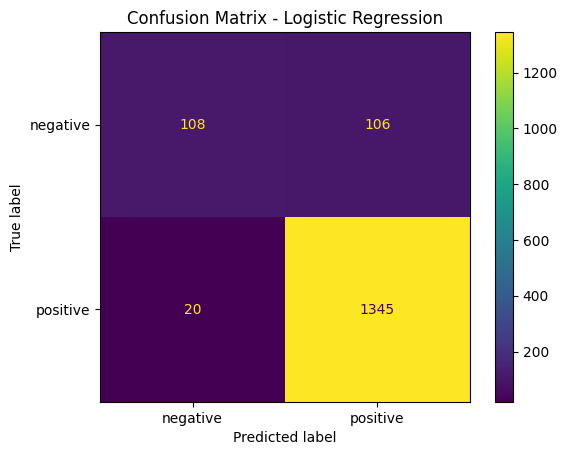

Logistic Regression F1: 0.9552556818181818


<Figure size 640x480 with 0 Axes>

In [10]:
with mlflow.start_run(run_name="TFIDF_LogisticRegression"):

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_tfidf, y_train)

    preds = lr.predict(X_test_tfidf)
    f1 = f1_score(y_test, preds, pos_label="positive")

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_metric("f1_score", f1)

    mlflow.sklearn.log_model(
        sk_model=lr,
        name="lr_model",
        registered_model_name="FlipkartSentimentModel"
    )

    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()

    mlflow.log_figure(plt.gcf(), "confusion_matrix_lr.png")

    sample_df = pd.DataFrame({
        "Review": X_test[:10],
        "Actual": y_test[:10],
        "Predicted": preds[:10]
    })

    sample_df.to_csv("sample_predictions_lr.csv", index=False)
    mlflow.log_artifact("sample_predictions_lr.csv")

print("Logistic Regression F1:", f1)

## Model Training with MLflow Tracking – Support Vector Machine (SVM)

A Support Vector Machine classifier is trained using TF-IDF features.
MLflow logs model parameters, performance metrics, and the trained model.

In [11]:
with mlflow.start_run(run_name="TFIDF_SVM"):

    svm = LinearSVC(C=1.0)
    svm.fit(X_train_tfidf, y_train)

    preds = svm.predict(X_test_tfidf)
    f1 = f1_score(y_test, preds, pos_label="positive")

    mlflow.log_param("model", "SVM")
    mlflow.log_param("C", 1.0)
    mlflow.log_metric("f1_score", f1)

    mlflow.sklearn.log_model(
        sk_model=svm,
        name="svm_model"
    )

    mlflow.set_tag("feature", "TF-IDF")
    mlflow.set_tag("type", "ML")

print("SVM F1:", f1)

SVM F1: 0.9586182079884851


## Hyperparameter Tuning with MLflow

Multiple SVM models are trained with different values of the regularization
parameter **C**. MLflow tracks each run to enable comparison of model performance.

In [12]:
for c in [0.1, 1.0, 10]:
    with mlflow.start_run(run_name=f"SVM_C_{c}", nested=True):

        svm = LinearSVC(C=c)
        svm.fit(X_train_tfidf, y_train)

        preds = svm.predict(X_test_tfidf)
        f1 = f1_score(y_test, preds, pos_label="positive")

        mlflow.log_param("C", c)
        mlflow.log_metric("f1_score", f1)

## Programmatic Run Summary

The MLflow Tracking API is used to retrieve completed experiment runs.
The table below summarizes the logged metrics and parameters for comparison.

In [14]:
runs = mlflow.search_runs()

required_runs = runs[
    (runs["tags.mlflow.runName"] == "TFIDF_LogisticRegression") |
    (runs["tags.mlflow.runName"] == "TFIDF_SVM") |
    (runs["tags.mlflow.runName"].str.startswith("SVM_C_"))
]

required_runs = required_runs[[
    "tags.mlflow.runName",
    "metrics.f1_score",
    "params.C",
    "params.model",
    "params.max_iter"
]]

required_runs

,tags.mlflow.runName,metrics.f1_score,params.C,params.model,params.max_iter
0,SVM_C_10,0.951069,10,None,None
1,SVM_C_1.0,0.958618,1.0,None,None
2,SVM_C_0.1,0.957356,0.1,None,None
3,TFIDF_SVM,0.958618,1.0,SVM,None
4,TFIDF_LogisticRegression,0.955256,None,LogisticRegression,1000


## MLflow Experiment Summary

MLflow was used to track multiple machine learning experiments for sentiment analysis.
Model parameters, evaluation metrics, artifacts, and trained models were logged.
Custom run names, model registry, tagging, metric plots, and hyperparameter comparisons
were demonstrated to ensure reproducibility and effective experiment management.